---
title: "Optimizer"
author:
    - name: Sumner Alperin
    - name: Adapted by Thuy Truong
date: "2024-07-05"
categories: [code]
image: "optimizer.png"
image-width: "1cm"
image-height: "1cm"
format:
    html:
        code-fold: false
        eval: true
jupyter: blogqa
code-annotations: hover
---

Explore the two different optimizers available through Tequila interfaces:    
A native gradient descent (GD) optimizer, as well as interfaces for SciPy optimizers.

In [51]:
#| output: false

import tequila as tq
import numpy as np
import matplotlib.pyplot as plt

# Overview

**How to optimize an `Objective`:**

 In `Tequila`, optimizers are accessed in several ways. They may be instantiated directly as objects and then called, or they can be accessed through the `tq.minimize`. Both methods require an `Objective`as an obligatory argument. Additionally, `tq.minimize`needs a `method`, which must be a string. The call methods of the GD and `SciPy` optimizers accept this key as well.
 
You can include the usual compilation kwargs for quantum simulation in `Tequila`as keywords to any optimization call. 

* `backend`, a string indicating which quantum simulator to use
* `samples`, an integer indicating the number of shots of the circuit to measure (None means full wavefunction simulation)
* `device`, generally a string indicating which (real or emulated) quantum computer to sample from (requires `samples` be specified)
* `noise`, the NoiseModel object to apply to the simulated circuits (see the tutorial on noise). 

Additional keywords you might use are:

* `variables`,  a `list` of the `Variables` you want to optimize (default is all).
* `initial_values`, which gives a start point to optimization. If you supply arguments to `variables`, you also need to supply arguments to `initial_values` so that all non-optimized parameters have a value to use. The default is random initialization (not recomended) 
* `gradient`, which specifies which type of gradient will be used : 
    * analytical gradients (Default): `gradient=None`
    * numerical gradients: `gradient={'method':'2-point', "stepsize":1.e-4}`
    * custom gradient objectives: `gradient={tq.Variable:tq.Objective}`
    * module specific gradients: `gradient="2-point"` (to use for example `SciPy` finite difference stencils)
* `silent`, silence outputs

Some of the optimizers take more, or different, keywords from the others, so check the documentation for each one. 
In case the optimizer has some degree of verbosity (currently, they all do), you can deactivate this with `silent=True`. 

The following optimization methods are available on your system in `Tequila`:

In [52]:
tq.optimizers.show_available_optimizers() #<1>

available methods for optimizer modules found on your system:
method               | optimizer module
--------------------------
NELDER-MEAD          | scipy
COBYLA               | scipy
POWELL               | scipy
SLSQP                | scipy
L-BFGS-B             | scipy
BFGS                 | scipy
CG                   | scipy
TNC                  | scipy
TRUST-KRYLOV         | scipy
NEWTON-CG            | scipy
DOGLEG               | scipy
TRUST-NCG            | scipy
TRUST-EXACT          | scipy
TRUST-CONSTR         | scipy
adam                 | gd
adagrad              | gd
adamax               | gd
nadam                | gd
sgd                  | gd
momentum             | gd
nesterov             | gd
rmsprop              | gd
rmsprop-nesterov     | gd
spsa                 | gd
gpyopt-lbfgs         | gpyopt
gpyopt-direct        | gpyopt
gpyopt-cma           | gpyopt
Supported optimizer modules:  ['scipy', 'gpyopt', 'gd']
Installed optimizer modules:  ['scipy', 'gd', 'gpyopt']


1. Get a list of all available optimizers

We will use two different `Objectives` for optimization in this tutorial.  
The first `Objective` $O_1$ computes a two qubit expectation value using the tractable but non-trivial hamiltonian $[Y(0)+Qm(0)]\otimes X(1)$, where $Qm=\frac{1}{2} (I - Z)$ is the projector onto the $\Ket{1}$ state. 

In [53]:
a = tq.Variable(name="a")*tq.numpy.pi       #<1>
b = tq.Variable(name="b")*tq.numpy.pi       #<1>
c = tq.Variable(name="c")*tq.numpy.pi       #<1>
d = tq.Variable(name='d')*tq.numpy.pi       #<1>

U1 = tq.gates.H(target=[0])                 #<2>
U1 += tq.gates.H(target=1)                  #<2>
U1 += tq.gates.Ry(target=0, angle=a)        #<2>
U1 += tq.gates.Rz(target=1, angle=b)        #<2>
U1 += tq.gates.Z(target=1,control=0)        #<2>
U1 += tq.gates.Rx(target=0, angle=c)        #<2>
U1 += tq.gates.Rx(target=1,angle=d)         #<2>
U1 += tq.gates.Z(target=1,control=0)        #<2>

H1=(tq.paulis.Y(0)+tq.paulis.Qm(0))*tq.paulis.X(1)  #<3>
O1=tq.ExpectationValue(U=U1,H=H1)                   #<4>

print('We will optimize the following objective: \n')

We will optimize the following objective: 



1. Optimizing the circuit in terms of pi makes the result of the optimization easier to interpret
2. Create a 2-qubit quantum circuit for the `Objective` $O_1$
3. Define the Hamiltonian for $O_1$ to optimize over 
4. Define the expectation value of the Hamiltonian after applying the quantum circuit

![](O1.png){width=60%}

Our second `Objective` $O_2$ will measure a 3-qubit circuit with respect to the Hamiltonian $Y(0)\otimes X(1) \otimes Y(2)$.

In [54]:
#<1>
U2 = tq.gates.Ry(tq.numpy.pi/2,0) +tq.gates.Ry(tq.numpy.pi/3,1)+tq.gates.Ry(tq.numpy.pi/4,2)  #<2>
U2 += tq.gates.Rz('a',0)+tq.gates.Rz('b',1)                                                   #<2>
U2 += tq.gates.CNOT(control=0,target=1)+tq.gates.CNOT(control=1,target=2)                     #<2>
U2 += tq.gates.Ry('c',1) +tq.gates.Rx('d',2)                                                  #<2>    
U2 += tq.gates.CNOT(control=0,target=1)+tq.gates.CNOT(control=1,target=2)                     #<2>

H2 = tq.paulis.Y(0)*tq.paulis.X(1)*tq.paulis.Y(2)                                             #<3>
O2 = tq.ExpectationValue(H=H2, U=U2)                                                          #<4>

print('We will optimize the following objective: \n')

We will optimize the following objective: 



1. This time, we don't optimize the circuit in terms of pi 
2. Create a 3-qubit quantum circuit for the `Objective` $O_2$
3. Define the Hamiltonian for $O_2$ to optimize over
4. Define the expectation value of the Hamiltonian after applying the quantum circuit

![](O2.png){width=80%}

# Local Optimizers

We will begin this tutorial by focusing on local optimizers.
Local optimization refers to any optimization schema where the suggested parameters at step $t$ are always a transformation of the parameters suggested at step $t-1$. This includes a large number of the standard optimization techniques in use today, like gradient descent.  

`Tequila` provides two local optimizers: a native gradient descent optimizer, implementing several popular gradient descent algorithms used in classical machine learning, as well as a plugin for the `SciPy` package (which is installed alongside `Tequila`), which allows the use of various gradient-free, gradient-based, and Hessian-based optimization methods.

## The GD Optimizer
We will start this tutorial by looking at the GD optimizer. Here is an overview over the available optimization methods.


In [55]:
tq.show_available_optimizers(module="gd")   #<1>

available methods for optimizer module gd
method               | optimizer module
--------------------------
adam                 | gd
adagrad              | gd
adamax               | gd
nadam                | gd
sgd                  | gd
momentum             | gd
nesterov             | gd
rmsprop              | gd
rmsprop-nesterov     | gd
spsa                 | gd


1. Get a list of all available optimization methods for the GD optimizer

A variety of methods are available for optimization. Here, 'sgd' refers to the standard gradient descent algorithm, without momentum. Like all Tequila optimizers, the GD optimizer has a `minimize` function and most of the arguments are the same. However, there is one important difference: the GD optimizer takes a learning rate (lr). This parameter mediates step size in all of the GD optimizer methods; It is a positive float which scales the step in the direction of the gradient. 


We will now optimize $O_1$, our two-qubit expectation value, starting with angles equivalent to $\frac{1}{4}\pi$ for all four variables, and optimizing via the ['Adam'](https://towardsdatascience.com/_adam-latest-trends-in-deep-learning-optimization-6be9a291375c) method.

In [56]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}              #<1>
lr=0.1                                                  #<2>

adam_result=tq.minimize(objective=O1,                   #<3>
                        lr=lr,                          #<3>
                        method='adam',                  #<3>
                        maxiter=80,                     #<3>
                        initial_values=init,            #<3>
                        silent=True)                    #<4>

1. Initialize all four variables to $\frac{1}{4}\pi$
2. Set the learning rate to 0.1
3. Optimize the objective $O_1$ using the `Adam` method with learning rate 0.1 and maximal iterations 80
4. Set silent=True to suppress output

The plots below show the trajectory of both the value of the objective and the values of the angles as a function of time.

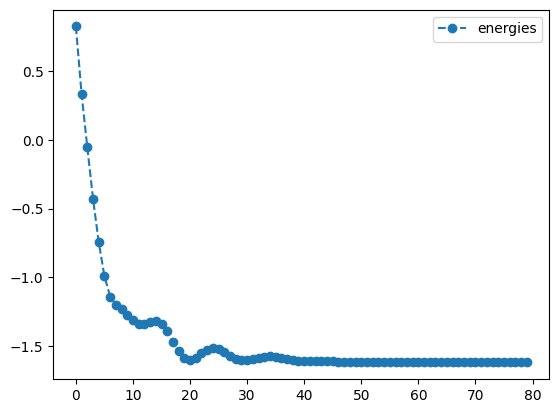

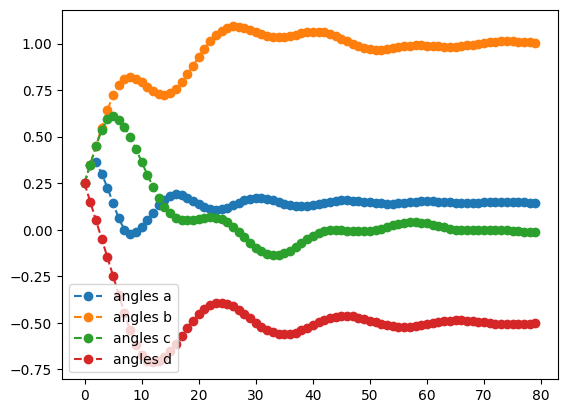

best energy:  -1.6179942179567814
optimal angles:  a : 0.14749685873977889
b : 1.0037045157384548
c : -0.0020942234687567523
d : -0.4982090391144128



In [57]:
adam_result.history.plot('energies')                #<1>
adam_result.history.plot('angles')                  #<2>
print('best energy: ',adam_result.energy)
print('optimal angles: ',adam_result.angles)

1. Plot energy from Adam optimization
2. Plot angles from Adam optimization

**We see that, apart from a few hiccups, all the angles converge to optimimal values.**

**Let's repeat what we did above, but with a few other methods! Here's RMSprop:**

RMSprop optimization results:


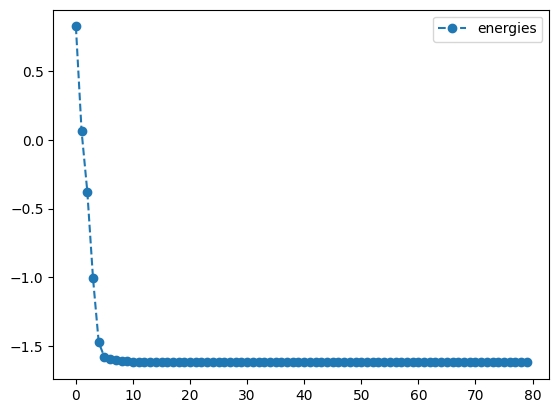

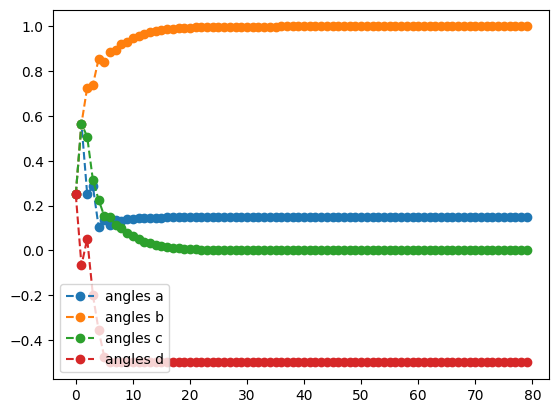

best energy:  -1.6180339887498942
optimal angles:  a : 0.14758361765043307
b : 0.9999999875406629
c : 1.498301743024053e-08
d : -0.5



In [58]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}          #<1>
lr=0.01                                             #<2>    

rms_result=tq.minimize(objective=O1,                #<3>
                       lr=lr,                       #<3>
                       method='rmsprop',            #<3> 
                       maxiter=80,                  #<3> 
                       initial_values=init,         #<3> 
                       silent=True)                 #<3>

print('RMSprop optimization results:')

rms_result.history.plot('energies')                 #<4>
rms_result.history.plot('angles')                   #<5>
print('best energy: ',rms_result.energy)
print('optimal angles: ',rms_result.angles)

1. Initialize all four variables to $\frac{1}{4}\pi$
2. Set the learning rate to 0.01
3. Optimize the objective $O_1$ using the `RMSprop` method with learning rate 0.01 and maximal iterations 80
4. Plot energy from RMSprop optimization
5. Plot angles from RMSprop optimization


**... And now let's take a look at Momentum:**

momentum optimization results:


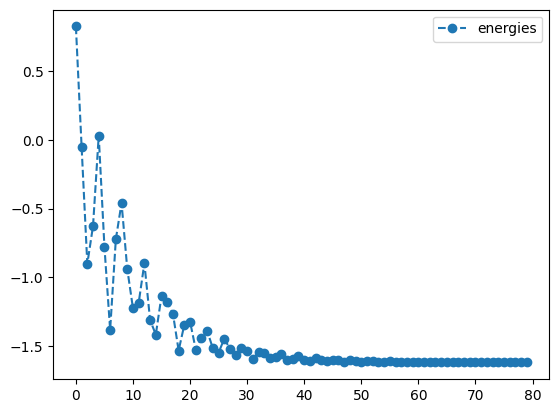

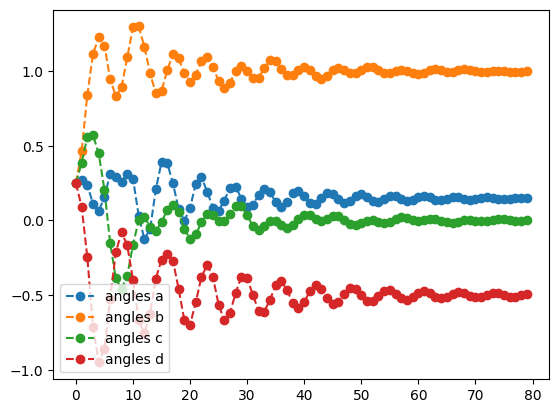

best energy:  -1.617816413662847
optimal angles:  a : 0.15313030387151333
b : 0.9975386772455798
c : -0.0008949810647826415
d : -0.5018117058023004



In [59]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}              #<1>    
lr=0.1                                                  #<2>

mom_result=tq.minimize(objective=O1,                    #<3>
                       lr=lr,                           #<3>   
                       method='momentum',               #<3>
                       maxiter=80,                      #<3>
                       initial_values=init,             #<3>
                       silent=True)                     #<3>

print('momentum optimization results:')                 
mom_result.history.plot('energies')                     #<4>
mom_result.history.plot('angles')                       #<5>
print('best energy: ',mom_result.energy)
print('optimal angles: ',mom_result.angles)

1. Initialize all four variables to $\frac{1}{4}\pi$
2. Set the learning rate to 0.1
3. Optimize the objective $O_1$ using the `Momentum` method with learning rate 0.1 and maximal iterations 80
4. Plot energy from Momentum optimization
5. Plot angles from Momentum optimization


Note that when using the [RMSprop](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a) method, we reduced the learning rate from $0.1$ to $0.01$. Different methods may be more or less sensitive to choices of initial learning rate. Feel free to revisit previous examples, and experiment with different learning rates, or initial parameters to gain insight into the sensitivity of different methods.

**Accelerated gradient descent to achieve numerical accuracy:**

One issue with gradient descent is that they are slow when it comes to converging to machine precision.
As optimization nears an optimum, the gradient goes to zero, which means that each successive step is smaller and smaller, and convergence slows down. This is not really a problem in machine learning, where convergence to many digits is not needed, but it is an issue in chemistry.

The standard method used to converge quantum chemical calculations is an accelerated form of gradient descent alternatively called `Direct Inversion of the Iterative Subspace (DIIS)` or `Pulay mixing` (for its inventor Peter Pulay). DIIS extrapolates from the error on past function evaluation to where the error is zero using a subspace approach. It is closely related to other subpsace and Krylov methods, such as `GMRES`.

DIIS works best once we are pretty close to our solution. In this case, we start from a significantly better initial guess, and try to achieve a tolerance of $\texttt{1e-10}$ with just standard gradient descent.


In [60]:
init={'a':0.18,'b':0.8,'c':-0.1,'d':-0.4}       #<1>
lr=0.1                                          #<2>

no_diis_result=tq.minimize(objective=O1,        #<3>
                           lr=lr,               #<3>
                           method='sgd',        #<3>
                           tol=1e-10,           #<3> 
                           maxiter=80,          #<3>
                           initial_values=init, #<3>
                           silent=True)         #<3>

1. Initialize variables: $a = 0.18$, $b = 0.8$, $c = -0.1$, $d = -0.4$
2. Set the learning rate to 0.1
3. Optimize the objective $O_1$ using the `standard gradient descent` method with learning rate 0.1, maximal iterations 80 and a tolerance of 1e-10


Looking at the printout (obtained with `silent=False` instead of `silent=True`), we see that convergence is achieved after 46 steps. We note that specifically convergence slows down significantly after 5 steps, as the gradients (and thus step sizes) become smaller the closer we get to the minima. This is the problem DIIS solves.

Let's try again with acceleration.

In [61]:
diis_result=tq.minimize(objective=O1,               #<1>
                        lr=lr,                      #<1>
                        method='sgd',               #<1>
                        diis={'tol':1e-1},          #<2>
                        tol=1e-10,                  #<1>
                        maxiter=80,                 #<1>
                        initial_values=init,        #<1>
                        silent=True)                #<1>

1. Optimize the objective $O_1$ using the `standard gradient descent` method with learning rate 0.1, maximal iterations 80, a tolerance of 1e-10 and DIIS acceleration
2. Set the DIIS acceleration with a tolerance of 1e-10

With the printout here (change to `silent=False`), the convergence is obtained in just 8 steps. We can see here that DIIS kicks in at step 3, that is, when $\texttt{max(gradient)}$ is below $\texttt{1e-1}$ (the `tol=` argument in the DIIS dictionary) and we have accumulated at least 3 vectors. Once DIIS starts, convergence is very rapid, with a four orders of magnitude drop in the error within just three steps.

We can see this most clearly in a logarithmic plot of the error.

SGD + DIIS optimization results:


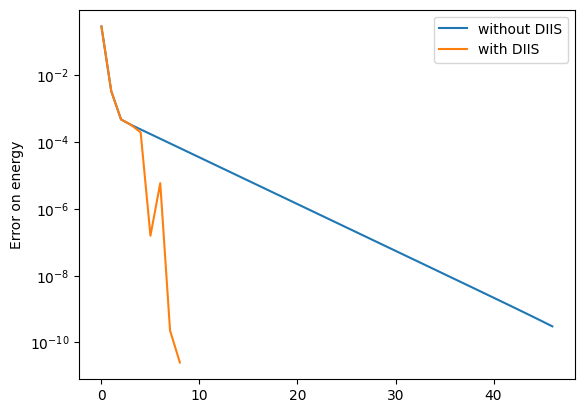

In [62]:
import numpy                                                                #<1>
                            
print('SGD + DIIS optimization results:')                                   

Emin = diis_result.history.energies[-1]                                     #<2>

plt.semilogy(numpy.asarray(no_diis_result.history.energies[:-1]) - Emin)    #<3>
plt.semilogy(numpy.asarray(diis_result.history.energies[:-1]) - Emin)       #<4>

plt.ylabel('Error on energy')                                               #<5>
plt.legend(['without DIIS', 'with DIIS'])                                   #<6>

1. Import the numpy library
2. Extract the last energy values from the DISS optimization
3. Plot the error on energy for every step in the optimization without DIIS acceleration
4. Plot the error on energy for every step in the optimization with DIIS acceleration
5. Label the y-axis of the plot as 'Error on Energy'
6. Add a legend to the plot to differentiate between the results with and without DIIS

We clearly see here that when DIIS kicks in, convergence rapidly accelerates. In comparison, the convergence rate of standard gradient descent actually slows down as we approach a solution. However, it should be noted that DIIS is not entirely stable and only really works close to an optima. Furthermore, the implementation here is somewhat experimental. Please use it at your own risk!

**The GD optimizer, with the Quantum Natural Gradient:**

The `Quantum Natural Gradient`, or QNG, is a novel method of calculating gradients for quantum systems, inspired by the natural gradient sometimes employed in classical machine learning. The usual gradient we employ is with respect to a Euclidean manifold, but this is not the only geometry -- nor even the optimal geometry -- of quantum space. The QNG is, in essence, a method of taking gradients with respect to (an approximation to) the Fubini-Study metric. For information on how (and why) the QNG is used, see [Stokes et.al](https://arxiv.org/abs/1909.02108). 

Using the QNG in Tequila is as simple as passing in the keyword `gradient='qng'` to optimizers which support it, such as the GD optimizer.  We will use it to optimize $O_2$, our 3 qubit `Objective`, and then compare the results to optimizing the same circuit with the regular gradient.

In [63]:
                                                                #<1>
init={k:np.random.uniform(-2,2) for k in ['a','b','c','d']}     #<2>
lr=0.01                                                         #<3>

qng_result = tq.minimize(objective=O2,                          #<4>
                         gradient='qng',                        #<5>
                         method='sgd',                          #<4>
                         maxiter=200,                           #<4>
                         lr=lr,                                 #<4>
                         initial_values=init,                   #<4>
                         silent=True)                           #<4>

1. keyword 'stop_count' stops optimization if no improvement occurs after 50 epochs
2. Initialize the four variables to random values between -2 and 2
3. Set the learning rate to 0.01
4. Optimize the objective $O_2$ using the `standard gradient descent` method with learning rate 0.01, maximal iterations 200 and the Quantum Natural Gradient (QNG)
5. Set the gradient to the Quantum Natural Gradient (QNG)

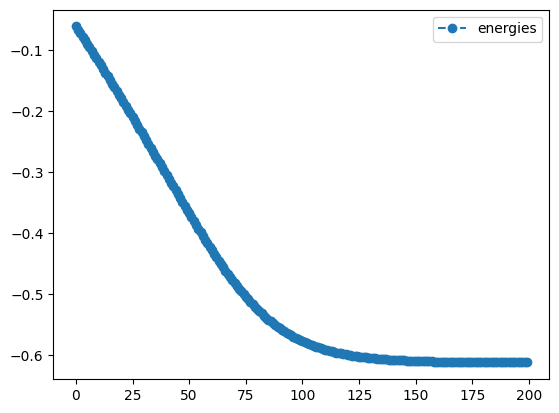

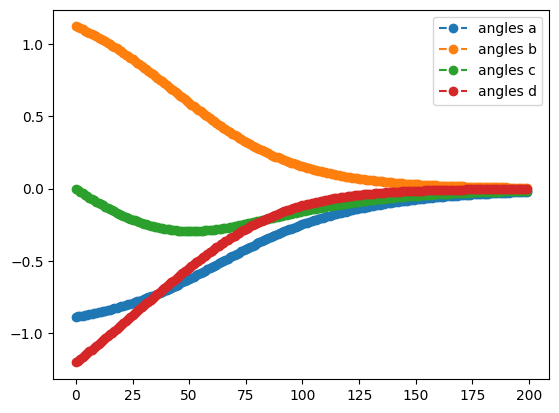

best energy with qng:  -0.6121445376182162
optimal angles with qng:  a : -0.02215857873260148
b : 0.0059525380064374455
c : -0.014680638935248558
d : -0.0017630474321783914



In [64]:
qng_result.history.plot('energies')                         #<1>
qng_result.history.plot('angles')                           #<2>

print('best energy with qng: ',qng_result.energy) 
print('optimal angles with qng: ',qng_result.angles)

1. Plot the energy from the optimization with the Quantum Natural Gradient
2. Plot the angles from the optimization with the Quantum Natural Gradient

To appreciate the benefits of using the QNG, let's optimize the same circuit with the same learning rate and method, but without QNG.

plotting what happens without QNG


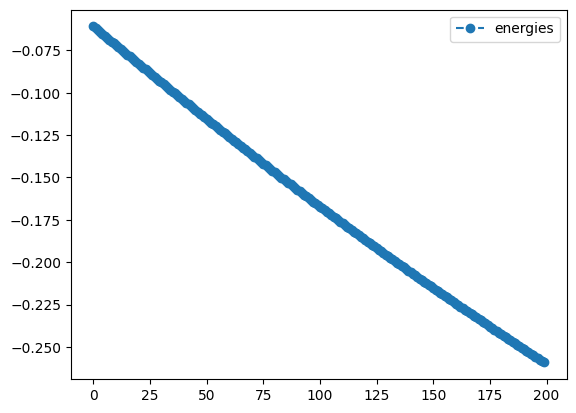

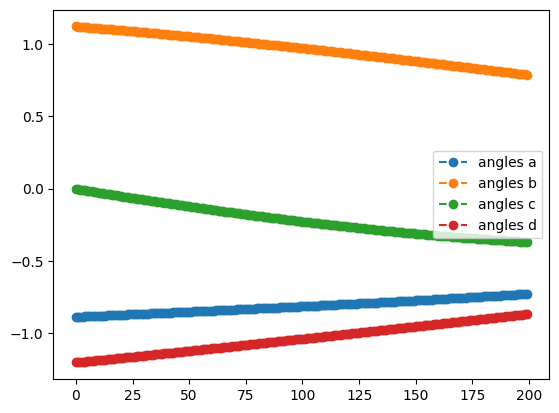

best energy without qng:  -0.2591823908378972
optimal angles without qng:  a : -0.7272578239465537
b : 0.7880495712796224
c : -0.368377646698078
d : -0.8675949678046627



In [65]:
lr=0.01                                                 #<1>

sgd_noqng_result = tq.minimize(objective=O2,            #<2>
                               gradient=None,           #<2>
                               method='sgd',            #<2>
                               maxiter=200,             #<2>
                               lr=lr,                   #<2>
                               initial_values=init,     #<2>
                               silent=True)             #<2>

print('plotting what happens without QNG')

sgd_noqng_result.history.plot('energies')               #<3>
sgd_noqng_result.history.plot('angles')                 #<4>

print('best energy without qng: ',sgd_noqng_result.energy)
print('optimal angles without qng: ',sgd_noqng_result.angles)

1. Set the learning rate to 0.01
2. Optimize the objective $O_2$ using the `standard gradient descent` method with learning rate 0.01 and maximal iterations 200
3. Plot the energy from the optimization without the Quantum Natural Gradient
4. Plot the angles from the optimization without the Quantum Natural Gradient

Although the starting point was random, you will most likely see that the QNG run achieved a greater degree of improvement - it will not perform worse - and that the trajectories followed by the angles were different from those in the SGD-only optimization. 
Feel free to play around with other methods, learning rates, or circuits in your own code!

## The SciPy Optimizer

`SciPy` is one of the most popular optimization packages in `Python`. It offers a wide variety of optimization strategies. We will not cover them here; for a full exploration of all the `SciPy` methods, see [their documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html). Instead, we will showcase a few of the more powerful options available. Most `SciPy` keywords like `method_options`, can be passed directly to `minimize` in the same way as when using `SciPy` directly.  

In [66]:
tq.show_available_optimizers(module="scipy")        #<1>

available methods for optimizer module scipy
method               | optimizer module
--------------------------
NELDER-MEAD          | scipy
COBYLA               | scipy
POWELL               | scipy
SLSQP                | scipy
L-BFGS-B             | scipy
BFGS                 | scipy
CG                   | scipy
TNC                  | scipy
TRUST-KRYLOV         | scipy
NEWTON-CG            | scipy
DOGLEG               | scipy
TRUST-NCG            | scipy
TRUST-EXACT          | scipy
TRUST-CONSTR         | scipy


1. Get a list of all available optimization methods for the SciPy optimizer

We will try three different optimizers: `COBYLA`, which is gradient-free; `L-BFGS-B`, which employs gradients; and `NEWTON-CG`, which employs the Hessian.

Aa a reminder, we will optimize:

![](O1.png){width=60%}

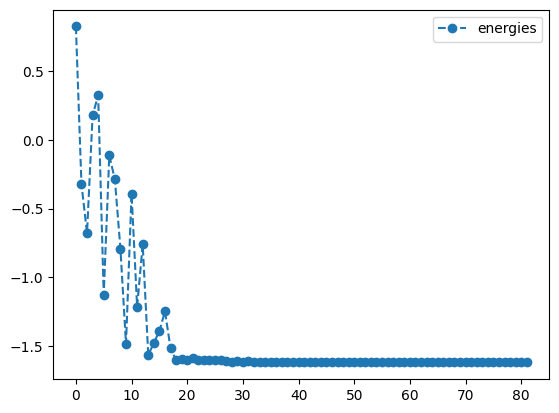

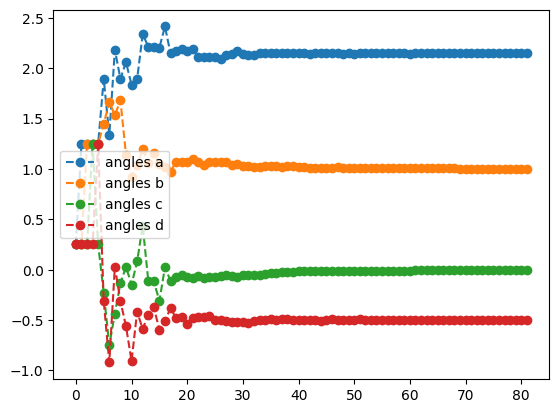

best energy with cobyla:  -1.618031464593162
optimal angles with cobyla:  a : 2.147373632733447
b : 1.0010269344671066
c : -0.0014082403580806177
d : -0.5000442705117792



In [67]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}                              #<1>

cobyla_result = tq.minimize(objective=O1,                               #<2>
                            method="cobyla",                            #<2>
                            initial_values=init,                        #<2>
                            tol=1.e-3,                                  #<2>
                            method_options={"gtol":1.e-3},              #<3>
                            silent=True)                                #<2>

cobyla_result.history.plot('energies')                                  #<4>
cobyla_result.history.plot('angles')                                    #<5>

print('best energy with cobyla: ',cobyla_result.energy)
print('optimal angles with cobyla: ',cobyla_result.angles)

1. Initialize all four variables to fixed values of $0.25$
2. Optimize the objective $O_1$ using the `COBYLA` method with a tolerance of $1.e-3$
3. Set the gradient tolerance to $1.e-3$
4. Plot the energy from the optimization with the COBYLA method
5. Plot the angles from the optimization with the COBYLA method

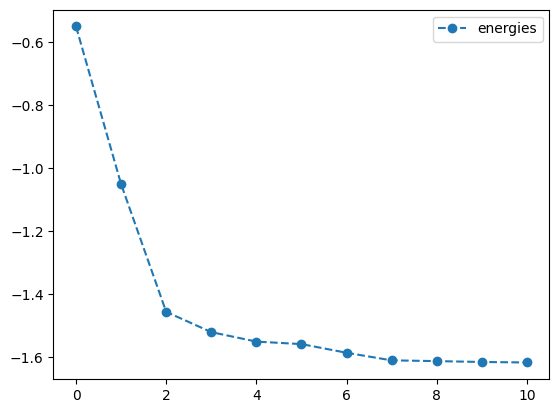

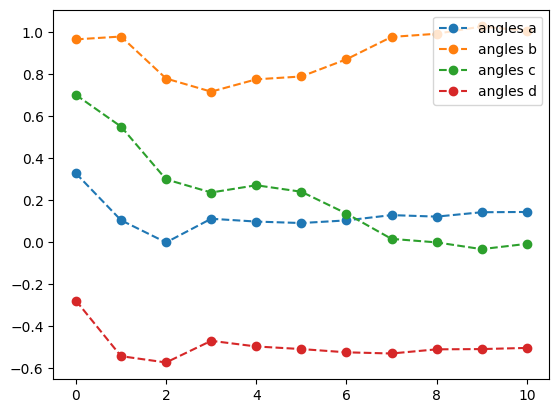

best energy with L-BFGS-B:  -1.6178070274606597
optimal angles with L-BFGS-B:  a : 0.14354397455393397
b : 1.0061132343244423
c : -0.008256863017895754
d : -0.5036909456037741



In [68]:
lb_result = tq.minimize(objective=O1,                       #<1>
                        method="l-bfgs-b",                  #<1>
                        initial_values=init,                #<1>
                        tol=1.e-3,                          #<1>
                        method_options={"gtol":1.e-3},      #<2>
                        silent=True)                        #<1>

lb_result.history.plot('energies')                          #<3>
lb_result.history.plot('angles')                            #<4>

print('best energy with L-BFGS-B: ',lb_result.energy)
print('optimal angles with L-BFGS-B: ',lb_result.angles)

1. Optimize the objective $O_1$ using the `L-BFGS-B` method with a tolerance of $1.e-3$
2. Set the gradient tolerance to $1.e-3$
3. Plot the energy from the optimization with the L-BFGS-B method
4. Plot the angles from the optimization with the L-BFGS-B method

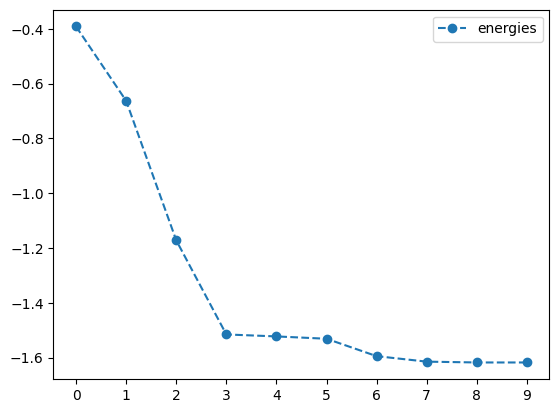

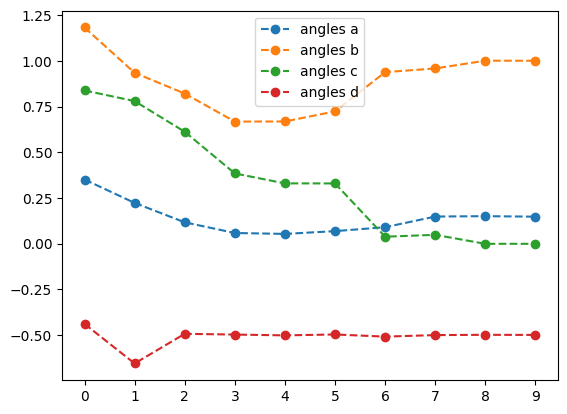

best energy with NEWTON-CG:  -1.618032396266234
optimal angles with NEWTON-CG:  a : 0.1475346588846646
b : 1.000870829234684
c : -0.0011056953828126209
d : -0.49984554761229166



In [69]:
newton_result = tq.minimize(objective=O1,                           #<1>
                            method="newton-cg",                     #<1>
                            initial_values=init,                    #<1>
                            tol=1.e-3,                              #<1>
                            method_options={"gtol":1.e-3},          #<2>
                            silent=True)                            #<1>

newton_result.history.plot('energies')                              #<3>
newton_result.history.plot('angles')                                #<4>

print('best energy with NEWTON-CG: ',newton_result.energy)
print('optimal angles with NEWTON-CG: ',newton_result.angles)

1. Optimize the objective $O_1$ using the `NEWTON-CG` method with a tolerance of $1.e-3$
2. Set the gradient tolerance to $1.e-3$
3. Plot the energy from the optimization with the NEWTON-CG method
4. Plot the angles from the optimization with the NEWTON-CG method

All three of the methods converged to the same minimum, but not necessarily to the same angles; the gradient and Hessian based methods converged to approximately the same angles in similar time. 

**Scipy Extras: numerical gradients and Hessians**

Scipy allows for the use of numerical gradients. To use them, pass down keywords to the `gradient` argument, such as `'2-point'`. When using the numerical gradients of `SciPy`, it is often crucial to determine a feasible step size for the procedure. This can be done with the `method_options` entry `finite_diff_rel_step` (for `SciPy` version 1.5 or higher) or `eps` (for `SciPy` version < 1.5).

Here is one example. 
**Please ensure to check your SciPy version!**

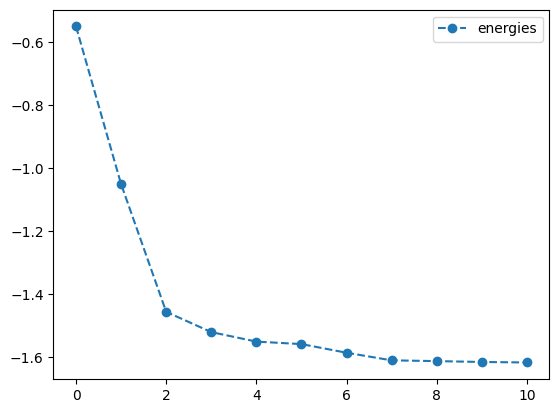

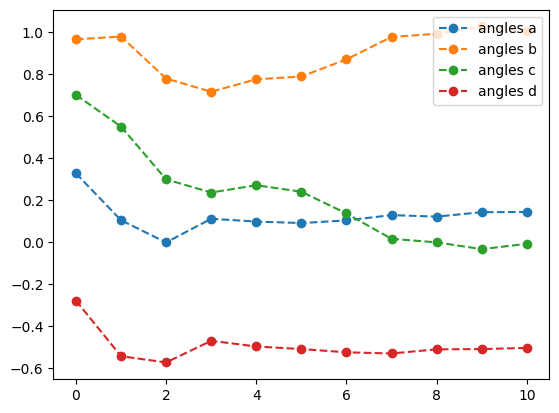

best energy with L-BFGS-B:  -1.6178082631717572
optimal angles with L-BFGS-B:  a : 0.1435263676387571
b : 1.0060019972486893
c : -0.00817836792105437
d : -0.5036839801675221



In [70]:
lb_result = tq.minimize(objective=O1,                                                   #<1>
                        method="l-bfgs-b",                                              #<1>
                        initial_values=init,                                            #<1>
                        gradient="2-point",                                             #<2>
                        tol=1.e-3,                                                      #<1>
                        method_options={"gtol":1.e-3, "finite_diff_rel_step":1.e-4},    #<3>
                        silent=True)                                                    #<1>

lb_result.history.plot('energies')                                                      #<4>
lb_result.history.plot('angles')                                                        #<5>

print('best energy with L-BFGS-B: ',lb_result.energy)
print('optimal angles with L-BFGS-B: ',lb_result.angles)

1. Optimize the objective $O_1$ using the `L-BFGS-B` method with a tolerance of $1.e-3$, numerical gradients, and a step size of $1.e-4$
2. Set the gradient to `2-point` to use numerical gradients
3. Set the step size to $1.e-4$
4. Plot the energy from the optimization with the L-BFGS-B method and numerical gradients
5. Plot the angles from the optimization with the L-BFGS-B method and numerical gradients

**Scipy Extras: the QNG in SciPy**  

Scipy is also configured to use the QNG, just as the GD optimizer is. All one needs to do is set `gradient=qng`.
Let's see how QNG interacts with the `BFGS` optimizer. We will use $0_2$, our 3-qubit expectation value, that we used previously.

plotting what happens with QNG


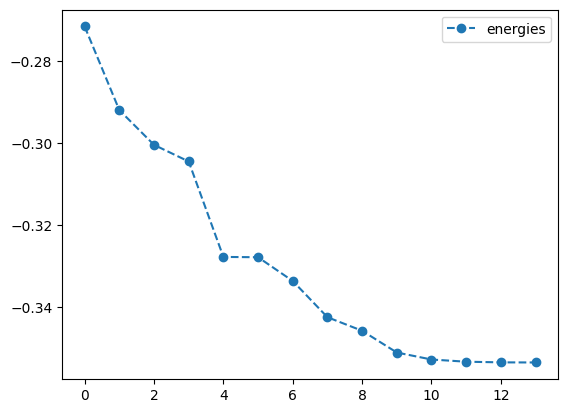

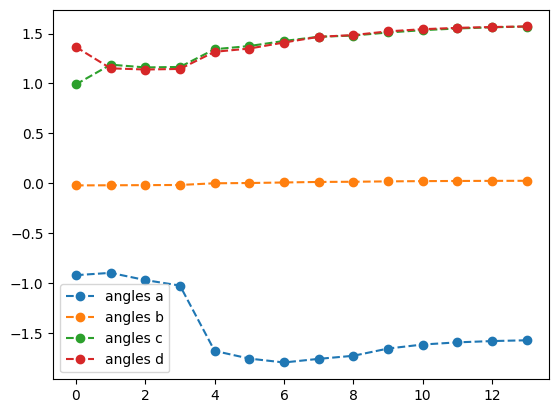

best energy with qng:  -0.3535533560030429
optimal angles with qng:  a : -1.57098151004744
b : 0.02566573196727211
c : 1.5704174098342945
d : 1.5706630278472251



In [71]:
init={k:np.random.uniform(-2,2) for k in ['a','b','c','d']}         #<1>
lr=0.01                                                             #<2>

bfgs_qng_result = tq.minimize(objective=O2,                         #<3>
                              gradient='qng',                       #<4>
                              method='bfgs',                        #<3>
                              maxiter=200,                          #<3>
                              lr=lr,                                #<3>
                              initial_values=init,                  #<3>
                              silent=True)                          #<3>

print('plotting what happens with QNG')

bfgs_qng_result.history.plot('energies')                            #<5>
bfgs_qng_result.history.plot('angles')                              #<6>

print('best energy with qng: ',bfgs_qng_result.energy)
print('optimal angles with qng: ',bfgs_qng_result.angles)

1. Initialize the four variables to random values between -2 and 2
2. Set the learning rate to 0.01
3. Optimize the objective $O_2$ using the `BFGS` method with learning rate 0.01, maximal iterations 200 and the Quantum Natural Gradient (QNG)
4. Set the gradient to the Quantum Natural Gradient (QNG)
5. Plot the energy from the optimization with the BFGS method and the Quantum Natural Gradient
6. Plot the angles from the optimization with the BFGS method and the Quantum Natural Gradient

plotting what happens without QNG


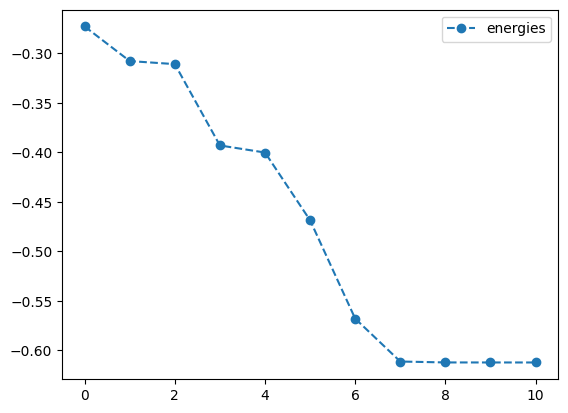

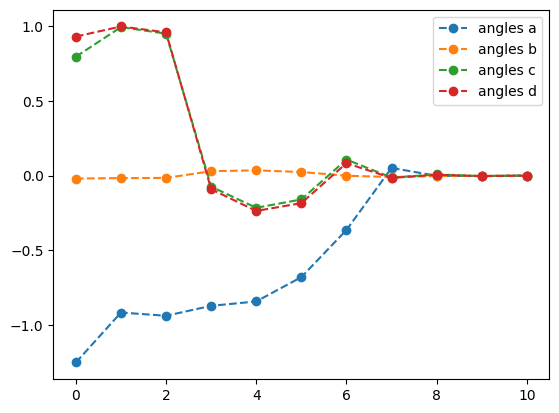

best energy without qng:  -0.6123722316299733
optimal angles without qng:  a : 0.00023318809750098347
b : -0.0007233623236951418
c : 5.297705957416901e-05
d : -0.00029333277886757145



In [72]:
bfgs_noqng_result = tq.minimize(objective=O2,                   #<1>
                                gradient=None,                  #<2>
                                method='bfgs',                  #<1>
                                maxiter=200,                    #<1>
                                lr=lr,                          #<1>
                                initial_values=init,            #<1>
                                silent=True)                    #<1>

print('plotting what happens without QNG')

bfgs_noqng_result.history.plot('energies')                      #<3>
bfgs_noqng_result.history.plot('angles')                        #<4>

print('best energy without qng: ',bfgs_noqng_result.energy)
print('optimal angles without qng: ',bfgs_noqng_result.angles)

1. Optimize the objective $O_2$ using the `BFGS` method with learning rate 0.01 and maximal iterations 200
2. Set the gradient to None
3. Plot the energy from the optimization with the BFGS method
4. Plot the angles from the optimization with the BFGS method

# Numerical and Customized Gradients

By default `Tequila` compiles analytical gradients of the objectives using `jax`, internal recompilation, and the parameter shift rule.
The default setting is not to set the `gradient` keyword or to set it to `None`.
The keyword can also be set to a dictionary, where keys are the variables and values are the `Tequila`objectives assumed to evaluate to the corresponding gradients of the objective. 
For example, `gradient=tq.grad(objective)` will result in the same behavior as `gradient=None` or simply not setting it.

`Tequila` offers its own way of compiling numerical gradients, which can then be used troughout all gradient-based optimizers. This can be activated by setting `gradient` to a dictionary holding the finite difference stencil as the `method`, as well as the `stepsize`.   

Numerical gradients of this type come with the cost of $2 \cdot$ `len(variables)` and can lead to significantly cheaper gradients, especially if many expectation values are involved in the objective and/or if heavy recompilation of parametrized gates is necessary. 
Here is a small example using our $O_2$ objective. Here, the numerical 2-point procedure leads to 4 expectation values in the gradients (while analytical gradients would lead to 8). You can set `silent` to `False` in the upper example or remove the `gradient` statement here for comparison.

In [73]:
lr=0.01                                                                     #<1>

num_result = tq.minimize(objective=O2,                                      #<2>
                        gradient={"method":"2-point", "stepsize":1.e-4},    #<3>
                        method='sgd',                                       #<2>
                        maxiter=200,                                        #<2>
                        lr=lr,                                              #<2>
                        initial_values=0.1,                                 #<2>
                        silent=True)                                        #<2>

1. Set the learning rate to 0.01
2. Optimize the objective $O_2$ using the `standard gradient descent` method with learning rate 0.01, maximal iterations 200 and numerical gradients with a step size of $1.e-4$
3. Set the gradient to a dictionary with the method `2-point` for numerical gradients and a step size of $1.e-4

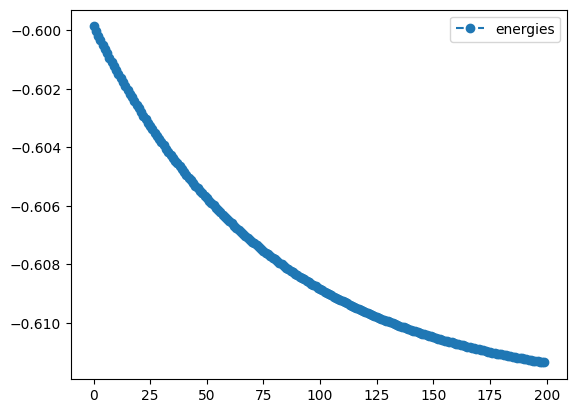

In [74]:
num_result.history.plot('energies')                             #<1>

1. Plot the energy from the 'standard gradient descent' optimization with numerical gradients

`Tequila` currently offers `2-point`, `2-point-forward` and `2-point-backward` stencils as `method`.
The method can also be set to a Python function performing the task. Here is an example that implements the same functionality as `2-point`. The function can be replaced by any function with the same signature.

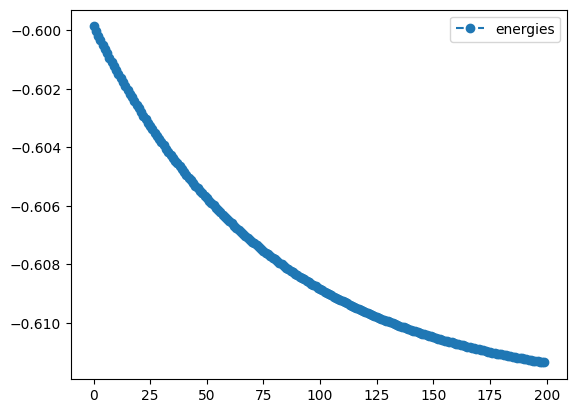

In [75]:
import copy                                                                                 #<1>

def my_finite_difference_stencil(obj, var_vals, key, step, *args, **kwargs):
        """
        calculate objective gradient by symmetric shifts about a point.
        Parameters
        ----------
        obj: Objective:
            objective to call.
        var_vals:
            variables to feed to the objective.
        key:
            which variable to shift, i.e, which variable's gradient is being called.
        step:
            the size of the shift; a small float.
        args
        kwargs

        Returns
        -------
        float:
            the approximated gradient of obj w.r.t variable key at point var_vals[key] as a float.

        """
        left = copy.deepcopy(var_vals)                                                      #<2>
        left[key] += step / 2                                                               #<3>
        right = copy.deepcopy(var_vals)                                                     #<4>
        right[key] -= step / 2                                                              #<5>
        return 1.0 / step * (obj(left, *args, **kwargs) - obj(right, *args, **kwargs))      #<6>

num_result = tq.minimize(objective=O2,                                                      #<7>
                         gradient={"method":my_finite_difference_stencil, "stepsize":1.e-4},#<8>
                         method='sgd',                                                      #<7>
                         maxiter=200,                                                       #<7>
                         lr=lr,                                                             #<7> 
                         initial_values=0.1,                                                #<7>
                         silent=True)                                                       #<7>

num_result.history.plot('energies')                                                         #<9>

1. Import the copy library to deep copy objects
2. Create a deep copy of the variable
3. Shift the variable to the right by half of the step size
4. Create another deep copy of the variable
5. Shift the variable to the left by half of the step size
6. Calculate the difference gradient using the symmetric difference quotient.
7. Optimize the objective $O_2$ using the `standard gradient descent` method with learning rate 0.01, maximal iterations 200 and an objective gradient with a step size of $1.e-4$
8. Set the gradient to a dictionary with the method `my_finite_difference_stencil` and a step size of $1.e-4$

The `gradient` keyword can also be replaced by a dictionary of `Tequila` objectives which evaluate to gradients approximations of it.